# Prison Cases over Time
This notebook uses the Marshall Project's data to visualize covid case numbers in prisons across the US.
Scroll to the bottom of the notebook for the map.

Geopandas handles geographic data. Folium is for creating the dynamic map.

In [1]:
import geopandas as gpd
import requests
import numpy as np
import pandas as pd
import datetime
from branca.colormap import linear
import folium
from folium.plugins import TimeSliderChoropleth

### Import the map overlay data
Download and save the geographic `json` data for the United States' boundaries.

In [2]:
url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
resp = requests.get(url)

with open('us-states.json', 'wb') as f:
    f.write(resp.content)

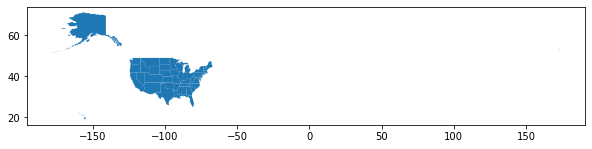

In [415]:
datapath = 'us-states.json'
gdf = gpd.read_file(datapath)
%matplotlib inline
ax = gdf.plot(figsize=(10,10))

Definitely the right country. I'd like to bring Alaska and Hawaii in though so that I can see everything up close.

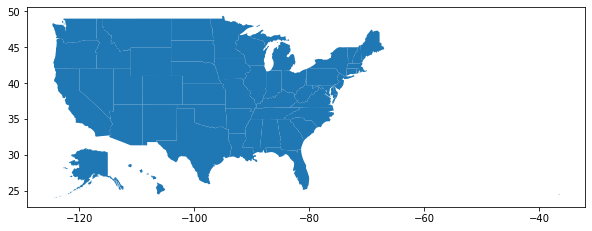

In [416]:
mask = gdf.id == "HI"
gdf[mask] = gdf[mask].set_geometry(gdf[mask].scale(1.3,1.3).translate(49,6))
mask = gdf.id == "AK"
gdf[mask] = gdf[mask].set_geometry(gdf[mask].scale(.25,.35).translate(-78,-34))
ax = gdf.plot(figsize=(10,10))

# Prep

### Import state prison covid counts

In [550]:
cases = pd.read_csv("covid_prison_cases.csv")
rates = pd.read_csv("covid_prison_rates.csv")

In [554]:
cases.head()

,name,abbreviation,staff_tests,staff_tests_with_multiples,total_staff_cases,staff_recovered,total_staff_deaths,prisoner_tests,prisoner_tests_with_multiples,total_prisoner_cases,prisoners_recovered,total_prisoner_deaths,as_of_date,notes
0,Alabama,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,AK,NaN,NaN,NaN,NaN,NaN,NaN,17155.0,2153.0,NaN,5.0,01/05/2021,NaN
2,Arizona,AZ,NaN,NaN,1930.0,1539.0,NaN,NaN,43016.0,7608.0,5781.0,39.0,01/05/2021,NaN
3,Arkansas,AR,NaN,NaN,NaN,NaN,4.0,NaN,NaN,10741.0,10455.0,51.0,01/05/2021,NaN
4,California,CA,NaN,NaN,12993.0,8962.0,11.0,NaN,115726.0,41562.0,33784.0,139.0,01/05/2021,NaN


In [555]:
rates.head()

,name,latest_week,cumulative_prisoner_cases,prisoner_cases_pct,prisoner_case_rate,cumulative_prisoner_deaths,prisoner_deaths_pct,prisoner_death_rate
0,Alabama,01/05/2021,1161,0.054987,1 in 18 prisoners,54,0.002558,1 in 391 prisoners
1,Alaska,01/05/2021,2153,0.450796,3 in 7 prisoners,5,0.001047,1 in 955 prisoners
2,Arizona,01/05/2021,7608,0.179603,1 in 6 prisoners,39,0.000921,1 in 1086 prisoners
3,Arkansas,01/05/2021,10741,0.613701,3 in 5 prisoners,51,0.002914,1 in 343 prisoners
4,California,01/05/2021,41562,0.353301,1 in 3 prisoners,139,0.001182,1 in 846 prisoners


Subset to just the rows with collection date and case count info. Exclude rows for the federal count.

In [382]:
cases = cases[cases['as_of_date'].notnull()]
cases = cases[cases['total_prisoner_cases'].notnull()]
cases = cases[cases['name'] != "Federal"]

Note that we have data for each state (only the first five shown here).

In [383]:
cases[['name','total_prisoner_cases','as_of_date']].head()

,name,total_prisoner_cases,as_of_date
1,Alaska,2153.0,01/05/2021
2,Arizona,7608.0,01/05/2021
3,Arkansas,10741.0,01/05/2021
4,California,41562.0,01/05/2021
5,Colorado,7512.0,01/05/2021


And for each state, we have data for many different points in time.

In [384]:
cases[['name','total_prisoner_cases','as_of_date']][cases['name']=='Tennessee'].head()

,name,total_prisoner_cases,as_of_date
41,Tennessee,6353.0,01/05/2021
92,Tennessee,6211.0,12/29/2020
143,Tennessee,6194.0,12/22/2020
194,Tennessee,6137.0,12/15/2020
245,Tennessee,6075.0,12/09/2020


### Create Index
Create a `DatetimeIndex` instance of the collection dates. This is necessary for use within Folium.

In [385]:
# Sort the dates
collection_dates = cases['as_of_date'].unique()
sorted_dates = sorted(collection_dates, key=lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

In [386]:
# Create the index
dt_index = pd.DatetimeIndex(sorted_dates).astype(int).astype("U10")

### Gather and Organize
Create a new dataframe from `cases`. It needs to have states in alphabetical order as the rownames, collection dates as the column names, and current prisoner cases as the values.

In [387]:
# Pull out a list of the states
states = cases["name"].unique()
states.sort() # alphabetized

In [388]:
# Create an empty dataframe with rows indexed by the alphabetical states
df = pd.DataFrame(index=states)

In [389]:
# Load that dataframe with the case values corresponding to each state and collection date.
for date in sorted_dates:
    names_cases = cases[cases['as_of_date']==date][['name','total_prisoner_cases']]
    df = pd.merge(df, names_cases, how='left', left_on=df.index, right_on="name")
    df.index = df['name']
    df.drop("name", axis=1, inplace=True)
    df.rename(columns={'total_prisoner_cases':date}, inplace = True)

The empty (`NaN`) values in this dataframe result from states submitting their data on different days.

For instance, you can see below that Alabama is the only one of these five states with a case count for the date `03/31/2020`. This means Alabama submitted data on that day, but none of those other four states did. On the next day, however, we hear from the other four states. 

If a state didn't report a case count on a given day, we will use their last reported count.

In [390]:
df.head()

,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/31/2020,04/01/2020,04/02/2020,04/03/2020,04/06/2020,04/07/2020,...,12/24/2020,12/27/2020,12/28/2020,12/29/2020,12/30/2020,12/31/2020,01/04/2021,01/05/2021,01/06/2021,01/07/2021
name,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,1161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1966.0,NaN,NaN,NaN,NaN,2153.0,NaN,NaN
Arizona,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6415.0,NaN,NaN,NaN,7608.0,NaN,NaN
Arkansas,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,10579.0,NaN,NaN,NaN,10741.0,NaN,NaN
California,NaN,NaN,1.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,38398.0,NaN,NaN,NaN,41562.0,NaN,NaN


In [391]:
# Change state name index to a numerical index (Alabama = 0, Wyoming = 49).
df_statenames = df.copy() # Save for later
df.index = np.arange(0,50)

### Create overlay
The Folium plugin for the choropleth map with a time slider takes two arguments:
1. A `geopandas` dataframe (converted to json)
2. The dictionary describing how to style the map overlay

We've already made the first thing. Now, we'll construct the second.

In [427]:
styledata = {}

for state in gdf.index:
    style_df = pd.DataFrame(
        {
            "color": np.array(df[df.index==state])[0], # cases over time for that state
            "opacity": np.ones(201) #* 0.75
        },
        index=dt_index,
    )
    style_df["color"].fillna(method="pad", inplace=True)
    style_df["color"].fillna(0, inplace=True)
    assert all(pd.notnull(style_df["color"]))
    styledata[state] = style_df

Now the map and the data are linked through the index running from `0` to `49`.

In [428]:
# Alabama's geographical info
gdf.loc[0]

id                                                         AL
name                                                  Alabama
geometry    POLYGON ((-87.359296 35.00118, -85.606675 34.9...
Name: 0, dtype: object

In [429]:
# Alabama's covid info
styledata.get(0).head()

,color,opacity
1585008000,0.0,1.0
1585094400,0.0,1.0
1585180800,0.0,1.0
1585267200,0.0,1.0
1585612800,0.0,1.0


The value of the color at each timestamp represents the number of prisoner cases for that state.
The opacity is fixed at 0.75 so you can see the underlying map.

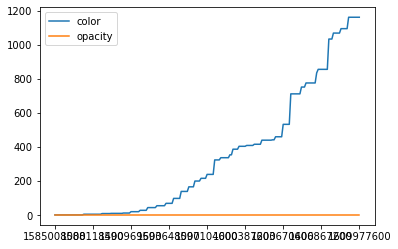

In [430]:
ax = styledata.get(0).plot()

Now, we represent each color value as a hex color.

In [431]:
max_color = 0

for _, data in styledata.items():
    max_color = max(data["color"].max(), max_color)
    min_color = 0 # A universal minimum allows us to compare one state's color to another.

Define and apply color maps: 

In [432]:
cmap = linear.YlOrRd_09.scale(min_color, max_color) # Issue: Change to logarithmic scale
for _, data in styledata.items():
    data["color"] = data["color"].apply(cmap)

In [433]:
styledata.get(0).head()

,color,opacity
1585008000,#ffffccff,1.0
1585094400,#ffffccff,1.0
1585180800,#ffffccff,1.0
1585267200,#ffffccff,1.0
1585612800,#ffffccff,1.0


Next, we convert each dataframe into a dictionary for use within Folium.

In [434]:
styledict = {
    str(state): data.to_dict(orient="index") for state, data in styledata.items()
}

Finally, we build the basemap and the overlay.

In [542]:
# The Overlay we care about
g = TimeSliderChoropleth(
    data=gdf.to_json(),
    styledict=styledict,
)

In [543]:
# Use an empty basemap to only show the overlay
m = folium.Map(location=[35,-96],
                zoom_start=4,
                tiles=None,
                zoom_control=False
               )

In [544]:
g.add_to(m)

In [545]:
m

Adding a legend will require a bit of a hack.

If this were a static choropleth overlay, a legend would come along for free. Since it isn't, we'll have to create a second overlay as a `folium.Choropleth` instance to get a legend. Then we'll set this new overlay's opacity to zero, leaving only its legend visible.

In [546]:
df_dict = {"name" : list(df_statenames.index),
           "counts_range" : max_color}

In [547]:
legend_df = pd.DataFrame(df_dict)
legend_df.iloc[0,1] = min_color
legend_df.head()

,name,counts_range
0,Alabama,0.0
1,Alaska,41562.0
2,Arizona,41562.0
3,Arkansas,41562.0
4,California,41562.0


In [548]:
folium.Choropleth(
    geo_data=gdf,
    bins=9,
    name="choropleth",
    data=legend_df,
    columns =['name','counts_range'],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0,
    line_opacity=1,
    legend_name="Prisoner Covid Cases by State",
).add_to(m)

In [549]:
m

Make sure to view the notebook through nbviewer so that the map renders properly. 
Alternatively, view the map by itself in GitHub Pages with the document below as the source.

In [409]:
m.save("index.html")

To do:
1. add legend √
2. logarithmic scale
3. create tooltips
4. hide the basemap √
5. Change geo data to inset Alaska and Hawaii √
6. visualize as a rate relative to total prisoner population
7. compare with staff cases